In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

In [16]:
%%capture
%run preprocessing.ipynb

# Load election data

In [18]:
elections = elections.query("election_year >= 1995 & election_year <= 2024")

# Select features for clustering

In [20]:
vs_cols = [c for c in elections.columns if c.startswith("vs_")]
cluster_features = vs_cols + ["fragmentation_enp", "polarization_dalton"]

print(f"Clustering on {len(cluster_features)} features:")
print(cluster_features)

Clustering on 13 features:
['vs_AGR', 'vs_CHR', 'vs_CON', 'vs_DIV', 'vs_ECO', 'vs_ETH', 'vs_LEF', 'vs_LIB', 'vs_NAT', 'vs_SIP', 'vs_SOC', 'fragmentation_enp', 'polarization_dalton']


#  Step 1: Create Calendar-Year Grid (1995-2024)

# For each country, interpolate data to annual values:
 - Linear interpolation between elections
 - NO extrapolation beyond last election
 - Result: All countries have data for years they participated in EU

In [21]:
def interpolate_to_annual(elections_df, features, year_range=(1995, 2024)):
    """
    Interpolate election data to annual calendar grid for each country.

    - Linear interpolation between elections
    - No extrapolation beyond last election
    - Each country gets data for years between first and last election
    - If multiple elections in same year, takes the last one
    """
    all_years = list(range(year_range[0], year_range[1] + 1))
    results = []

    for geo in elections_df.index.get_level_values('geo').unique():
        country_data = elections_df.loc[geo][features].copy()

        # Handle duplicate years (multiple elections in same year)
        # Keep the last election in each year
        if country_data.index.duplicated().any():
            country_data = country_data[~country_data.index.duplicated(keep='last')]

        # Sort by year to ensure proper interpolation
        country_data = country_data.sort_index()

        # Get first and last election years
        election_years = country_data.index.tolist()
        first_year = min(election_years)
        last_year = max(election_years)

        # Create annual index for this country's active period
        country_years = [y for y in all_years if first_year <= y <= last_year]

        # Reindex to annual and interpolate
        country_annual = country_data.reindex(country_years)

        # Interpolate using pandas interpolate (handles NaN between values)
        country_annual = country_annual.interpolate(method='linear', limit_area='inside')

        # Create result dataframe with proper structure
        result_df = pd.DataFrame({
            'geo': geo,
            'year': country_years
        })

        # Add all features
        for feat in features:
            result_df[feat] = country_annual[feat].values

        results.append(result_df)

    # Combine all countries
    annual_data = pd.concat(results, ignore_index=True)
    annual_data = annual_data.set_index(['geo', 'year'])

    return annual_data

annual_elections = interpolate_to_annual(elections, cluster_features)

print(f"\nAnnual data shape: {annual_elections.shape}")
print(f"Countries: {annual_elections.index.get_level_values('geo').nunique()}")
print(f"Years: {annual_elections.index.get_level_values('year').nunique()}")
print(f"\nSample data:")
print(annual_elections.head(10))


Annual data shape: (626, 13)
Countries: 26
Years: 29

Sample data:
          vs_AGR    vs_CHR  vs_CON  vs_DIV    vs_ECO  vs_ETH    vs_LEF  \
geo year                                                                 
AT  1995     0.0  28.29100     0.0     0.0   4.81500     0.0  0.000000   
    1996     0.0  27.94575     0.0     0.0   5.46125     0.0  0.000000   
    1997     0.0  27.60050     0.0     0.0   6.10750     0.0  0.000000   
    1998     0.0  27.25525     0.0     0.0   6.75375     0.0  0.000000   
    1999     0.0  26.91000     0.0     0.0   7.40000     0.0  0.000000   
    2000     0.0  32.04000     0.0     0.0   8.09000     0.0  0.187333   
    2001     0.0  37.17000     0.0     0.0   8.78000     0.0  0.374667   
    2002     0.0  42.30000     0.0     0.0   9.47000     0.0  0.562000   
    2003     0.0  40.30750     0.0     0.0   9.86500     0.0  0.421500   
    2004     0.0  38.31500     0.0     0.0  10.26000     0.0  0.281000   

           vs_LIB     vs_NAT  vs_SIP     vs

# Step 2: Within-Country Standardization

# Standardize each feature within each country (not EU-wide):
 - For each country, compute mean and std of each feature across years
 - Standardize: (value - country_mean) / country_std
 - This captures each country's own trajectory relative to its baseline

In [22]:
def standardize_within_country(data, features):
    """
    Standardize features within each country.

    For each country separately:
        standardized_value = (value - country_mean) / country_std

    This removes country-specific levels and focuses on within-country change.
    """
    standardized = data.copy()

    for geo in data.index.get_level_values('geo').unique():
        # Get country data
        country_mask = data.index.get_level_values('geo') == geo
        country_data = data.loc[country_mask][features]

        # Compute country-specific mean and std
        country_mean = country_data.mean()
        country_std = country_data.std()

        # Avoid division by zero (if std=0, feature is constant)
        country_std = country_std.replace(0, 1)

        # Standardize and assign back using the mask
        standardized.loc[country_mask, features] = (country_data - country_mean) / country_std

    return standardized

standardized_data = standardize_within_country(annual_elections, cluster_features)

print("\nWithin-country standardized data:")
print(standardized_data.head(10))

# Check: each country should now have mean ≈ 0, std ≈ 1 for each feature
print("\nValidation - Germany's standardized data should have mean≈0, std≈1:")
de_data = standardized_data.loc['DE'][cluster_features]
print(f"Means: {de_data.mean().round(3).to_dict()}")
print(f"Stds: {de_data.std().round(3).to_dict()}")


Within-country standardized data:
          vs_AGR    vs_CHR  vs_CON  vs_DIV    vs_ECO  vs_ETH    vs_LEF  \
geo year                                                                 
AT  1995     0.0 -0.426178     0.0     0.0 -2.159702     0.0 -0.787268   
    1996     0.0 -0.489422     0.0     0.0 -1.873018     0.0 -0.787268   
    1997     0.0 -0.552666     0.0     0.0 -1.586335     0.0 -0.787268   
    1998     0.0 -0.615911     0.0     0.0 -1.299651     0.0 -0.787268   
    1999     0.0 -0.679155     0.0     0.0 -1.012968     0.0 -0.787268   
    2000     0.0  0.260579     0.0     0.0 -0.706876     0.0  0.009585   
    2001     0.0  1.200314     0.0     0.0 -0.400785     0.0  0.806438   
    2002     0.0  2.140048     0.0     0.0 -0.094693     0.0  1.603291   
    2003     0.0  1.775054     0.0     0.0  0.080533     0.0  1.005651   
    2004     0.0  1.410060     0.0     0.0  0.255759     0.0  0.408012   

            vs_LIB    vs_NAT    vs_SIP    vs_SOC  fragmentation_enp  \
geo y

 ## Step 3: Reshape to Country-Level Sequences

- Create a 3D tensor: (countries, years, features)
- This allows us to compute distances between entire country trajectories

In [23]:
def create_trajectory_tensor(data, features, year_range=(1995, 2024)):
    """
    Reshape data to tensor: (countries, years, features)

    Missing values (years before first election) are set to NaN.
    """
    all_years = list(range(year_range[0], year_range[1] + 1))
    countries = sorted(data.index.get_level_values('geo').unique())

    n_countries = len(countries)
    n_years = len(all_years)
    n_features = len(features)

    tensor = np.full((n_countries, n_years, n_features), np.nan)

    for i, geo in enumerate(countries):
        if geo in data.index.get_level_values('geo'):
            country_data = data.loc[geo][features]
            for j, year in enumerate(all_years):
                if year in country_data.index:
                    tensor[i, j, :] = country_data.loc[year].values

    return tensor, countries, all_years

tensor, countries, years = create_trajectory_tensor(standardized_data, cluster_features)

print(f"\nTrajectory tensor shape: {tensor.shape}")
print(f"  Countries: {tensor.shape[0]}")
print(f"  Years: {tensor.shape[1]}")
print(f"  Features: {tensor.shape[2]}")
print(f"\nNaN fraction: {np.isnan(tensor).mean():.2%}")


Trajectory tensor shape: (26, 30, 13)
  Countries: 26
  Years: 30
  Features: 13

NaN fraction: 19.74%


In [24]:
# Diagnostic: Show which years each country has data for
print("\n" + "="*80)
print("DATA COVERAGE BY COUNTRY")
print("="*80)
for i, geo in enumerate(countries):
    # Check which years have data (not NaN)
    has_data = ~np.isnan(tensor[i, :, 0])  # Check first feature
    year_indices = np.where(has_data)[0]

    if len(year_indices) > 0:
        first_year = years[year_indices[0]]
        last_year = years[year_indices[-1]]
        n_years = len(year_indices)
        print(f"{geo}: {first_year}-{last_year} ({n_years} years)")
    else:
        print(f"{geo}: NO DATA")

# Show coverage matrix visually
print("\n" + "="*80)
print("VISUAL DATA COVERAGE (each dot = year with data)")
print("="*80)
print(f"{'Country':<8} 1995 {'':>7} 2005 {'':>7} 2015 {'':>7} 2024")
print("-" * 80)

for i, geo in enumerate(countries):
    has_data = ~np.isnan(tensor[i, :, 0])
    coverage_str = ''.join(['█' if has_data[j] else ' ' for j in range(len(years))])
    print(f"{geo:<8} {coverage_str}")


DATA COVERAGE BY COUNTRY
AT: 1995-2019 (25 years)
BE: 1995-2019 (25 years)
BG: 1997-2017 (21 years)
CY: 1996-2016 (21 years)
DE: 1998-2021 (24 years)
DK: 1998-2019 (22 years)
EE: 1995-2019 (25 years)
ES: 1996-2023 (28 years)
FI: 1995-2019 (25 years)
FR: 1997-2022 (26 years)
GR: 1996-2023 (28 years)
HR: 1995-2020 (26 years)
HU: 1998-2022 (25 years)
IE: 1997-2020 (24 years)
IT: 1996-2018 (23 years)
LT: 1996-2020 (25 years)
LU: 1999-2013 (15 years)
LV: 1995-2022 (28 years)
MT: 1996-2022 (27 years)
NL: 1998-2021 (24 years)
PL: 1997-2019 (23 years)
PT: 1995-2022 (28 years)
RO: 1996-2016 (21 years)
SE: 1998-2022 (25 years)
SI: 1996-2018 (23 years)
SK: 1998-2016 (19 years)

VISUAL DATA COVERAGE (each dot = year with data)
Country  1995         2005         2015         2024
--------------------------------------------------------------------------------
AT       █████████████████████████     
BE       █████████████████████████     
BG         █████████████████████       
CY        ██████████

# Step 4: Compute Pairwise Euclidean Distances

 For each pair of countries, compute Euclidean distance across all years and features.

 Distance = sqrt(sum((country_i - country_j)^2) over all years and features)

 We only include years where BOTH countries have data (overlapping period).

In [25]:
def compute_pairwise_distances(tensor, countries):
    """
    Compute Euclidean distance between country trajectories.

    Only considers overlapping time periods (where both countries have data).
    """
    n_countries = len(countries)
    D = np.zeros((n_countries, n_countries))

    for i in range(n_countries):
        for j in range(i + 1, n_countries):
            # Get trajectories for both countries
            traj_i = tensor[i]  # (years, features)
            traj_j = tensor[j]  # (years, features)

            # Find years where both have data
            valid_i = ~np.isnan(traj_i).any(axis=1)
            valid_j = ~np.isnan(traj_j).any(axis=1)
            valid_both = valid_i & valid_j

            if valid_both.sum() > 0:
                # Compute Euclidean distance over overlapping period
                diff = traj_i[valid_both] - traj_j[valid_both]
                dist = np.sqrt(np.sum(diff ** 2))
                D[i, j] = D[j, i] = dist
            else:
                # No overlap: set to large distance
                D[i, j] = D[j, i] = np.inf

    return D

distance_matrix = compute_pairwise_distances(tensor, countries)

print(f"\nDistance matrix shape: {distance_matrix.shape}")
print(f"Min distance: {distance_matrix[distance_matrix > 0].min():.2f}")
print(f"Max distance: {distance_matrix[distance_matrix < np.inf].max():.2f}")
print(f"Mean distance: {distance_matrix[distance_matrix < np.inf].mean():.2f}")


Distance matrix shape: (26, 26)
Min distance: 11.22
Max distance: 24.82
Mean distance: 17.66


# Step 5: Hierarchical Clustering with Ward Linkage

 Ward linkage minimizes within-cluster variance.
 Note: Ward requires actual data (not precomputed distances), so we flatten the tensor.


WARD HIERARCHICAL CLUSTERING
Data shape: (26, 390) (countries × years*features)
Testing K values: [2, 3, 4, 5]

K=2: Silhouette=0.0849
K=3: Silhouette=0.0453
K=4: Silhouette=0.0451
K=5: Silhouette=0.0407


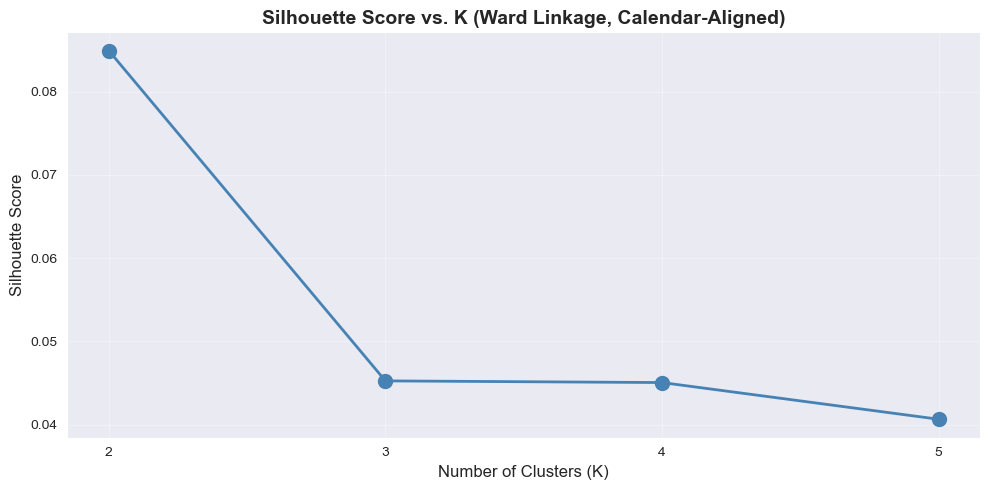


BEST K BY SILHOUETTE: 2



In [26]:
def cluster_with_ward(tensor, countries, k_values=[2, 3, 4, 5]):
    """
    Perform Ward hierarchical clustering on country trajectories.

    Ward linkage requires actual data, not precomputed distances.
    So we flatten the tensor to (countries, years*features) and cluster.

    Parameters:
        tensor: (n_countries, n_years, n_features) array
        countries: list of country codes
        k_values: list of K values to try

    Returns:
        results: dict with clustering results for each K
        best_k: K with highest silhouette score
    """
    # Flatten tensor: (countries, years*features)
    n_countries, n_years, n_features = tensor.shape
    X = tensor.reshape(n_countries, n_years * n_features)

    # Handle NaN values
    # Option 1: Replace with 0 (neutral after standardization)
    X_filled = np.nan_to_num(X, nan=0)

    # Alternative Option 2: Only use complete cases (countries with no NaN)
    # complete_mask = ~np.isnan(X).any(axis=1)
    # X_complete = X[complete_mask]
    # countries_complete = [c for i, c in enumerate(countries) if complete_mask[i]]

    results = {}

    print(f"\n{'='*80}")
    print(f"WARD HIERARCHICAL CLUSTERING")
    print(f"{'='*80}")
    print(f"Data shape: {X_filled.shape} (countries × years*features)")
    print(f"Testing K values: {k_values}\n")

    for k in k_values:
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(X_filled)

        # Compute silhouette score
        sil = silhouette_score(X_filled, labels)

        results[k] = {
            'labels': labels,
            'silhouette': sil,
            'model': model
        }

        print(f"K={k}: Silhouette={sil:.4f}")

    # Plot silhouette scores
    fig, ax = plt.subplots(figsize=(10, 5))
    ks = list(results.keys())
    sils = [results[k]['silhouette'] for k in ks]
    ax.plot(ks, sils, 'o-', linewidth=2, markersize=10, color='steelblue')
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title('Silhouette Score vs. K (Ward Linkage, Calendar-Aligned)',
                 fontsize=14, weight='bold')
    ax.grid(alpha=0.3)
    ax.set_xticks(ks)
    plt.tight_layout()
    plt.show()

    # Choose best K
    best_k = max(results.keys(), key=lambda k: results[k]['silhouette'])
    print(f"\n{'='*80}")
    print(f"BEST K BY SILHOUETTE: {best_k}")
    print(f"{'='*80}\n")

    return results, best_k

clustering_results, best_k = cluster_with_ward(tensor, countries, k_values=[2, 3, 4, 5])


#  Step 6: Visualize Dendrogram

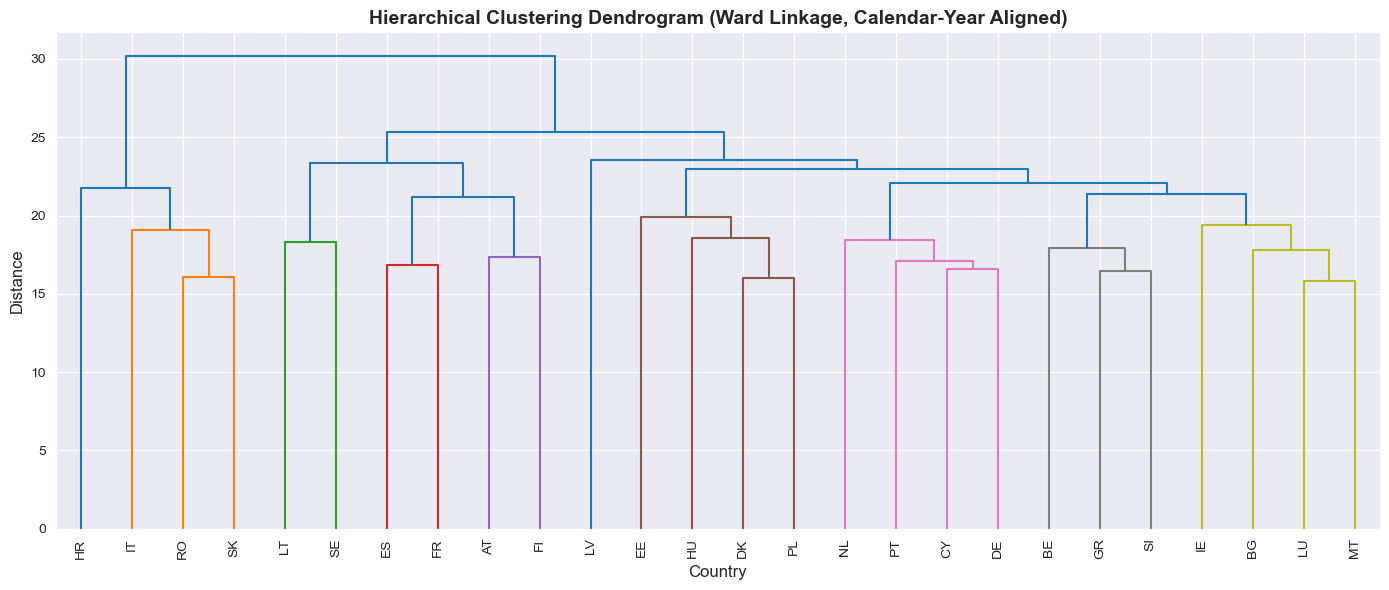

In [27]:
def plot_dendrogram_from_tensor(tensor, countries):
    """
    Create dendrogram using Ward linkage on flattened trajectories.
    """
    # Flatten and impute
    n_countries, n_years, n_features = tensor.shape
    X = tensor.reshape(n_countries, n_years * n_features)
    X_filled = np.nan_to_num(X, nan=0)

    # Compute linkage
    Z = linkage(X_filled, method='ward')

    # Plot
    plt.figure(figsize=(14, 6))
    dendrogram(Z, labels=countries, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram (Ward Linkage, Calendar-Year Aligned)',
              fontsize=14, weight='bold')
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.show()

    return Z

Z = plot_dendrogram_from_tensor(tensor, countries)

#  Step 7: Analyze Clusters

In [28]:
def analyze_clusters(clustering_results, best_k, countries, standardized_data, cluster_features):
    """
    Analyze cluster membership and characteristics.
    """
    labels = clustering_results[best_k]['labels']

    # Create clusters DataFrame
    clusters_df = pd.DataFrame({
        'geo': countries,
        'cluster': labels
    }).sort_values(['cluster', 'geo'])

    print(f"\n{'='*80}")
    print(f"CLUSTER ANALYSIS (K={best_k})")
    print(f"{'='*80}\n")

    for cluster_id in sorted(clusters_df['cluster'].unique()):
        cluster_countries = clusters_df[clusters_df['cluster'] == cluster_id]['geo'].tolist()
        print(f"\n** Cluster {cluster_id} ({len(cluster_countries)} countries) **")
        print(f"Countries: {', '.join(sorted(cluster_countries))}")

        # Compute cluster mean trajectory
        cluster_data = standardized_data[standardized_data.index.get_level_values('geo').isin(cluster_countries)]
        cluster_mean = cluster_data.groupby('year')[cluster_features].mean()

        # Identify defining features (largest absolute mean change)
        overall_change = cluster_mean.iloc[-1] - cluster_mean.iloc[0]
        top_increasing = overall_change.nlargest(3)
        top_decreasing = overall_change.nsmallest(3)

        print("\nDefining trends (1995-2024):")
        print("  Increasing:")
        for feat, val in top_increasing.items():
            print(f"    {feat}: +{val:.2f} std")
        print("  Decreasing:")
        for feat, val in top_decreasing.items():
            print(f"    {feat}: {val:.2f} std")

    return clusters_df

clusters_df = analyze_clusters(clustering_results, best_k, countries,
                                standardized_data, cluster_features)


CLUSTER ANALYSIS (K=2)


** Cluster 0 (22 countries) **
Countries: AT, BE, BG, CY, DE, DK, EE, ES, FI, FR, GR, HU, IE, LT, LU, LV, MT, NL, PL, PT, SE, SI

Defining trends (1995-2024):
  Increasing:
    vs_NAT: +2.45 std
    vs_LEF: +1.23 std
    vs_ECO: +0.99 std
  Decreasing:
    vs_LIB: -1.14 std
    vs_SOC: -0.72 std
    vs_ETH: -0.40 std

** Cluster 1 (4 countries) **
Countries: HR, IT, RO, SK

Defining trends (1995-2024):
  Increasing:
    fragmentation_enp: +1.91 std
    vs_SOC: +1.60 std
    vs_AGR: +0.00 std
  Decreasing:
    vs_ETH: -3.76 std
    polarization_dalton: -2.16 std
    vs_LEF: -0.30 std


#  Step 8: Visualize Cluster Trajectories

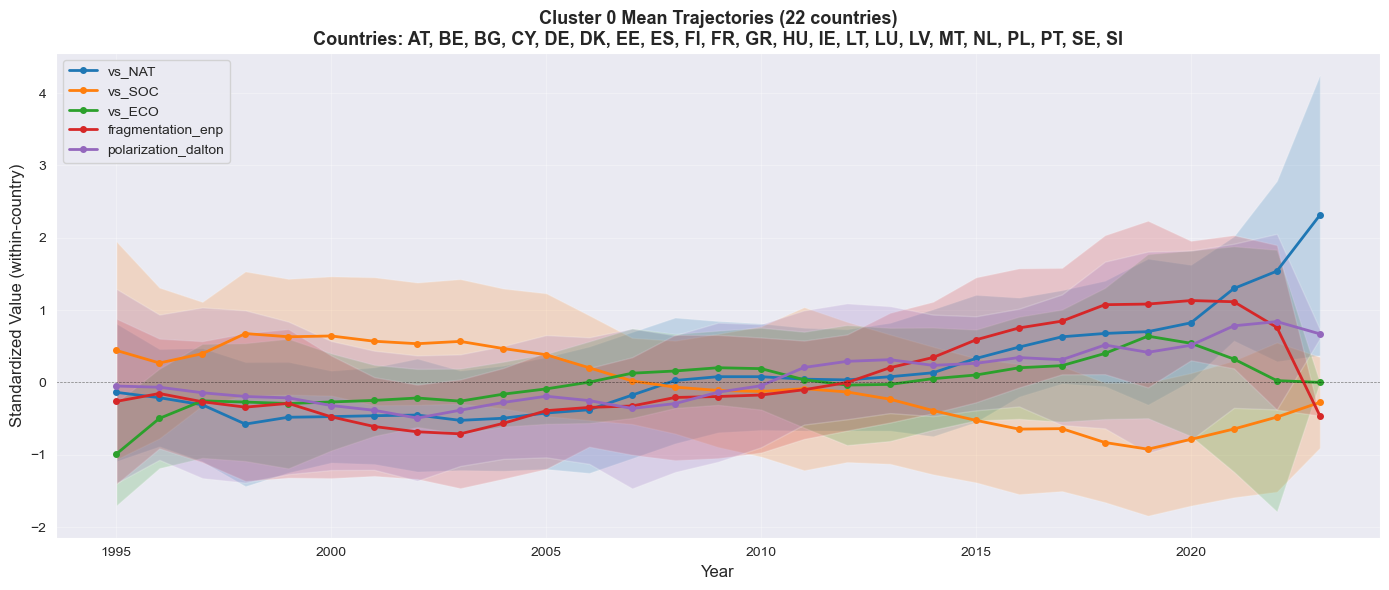

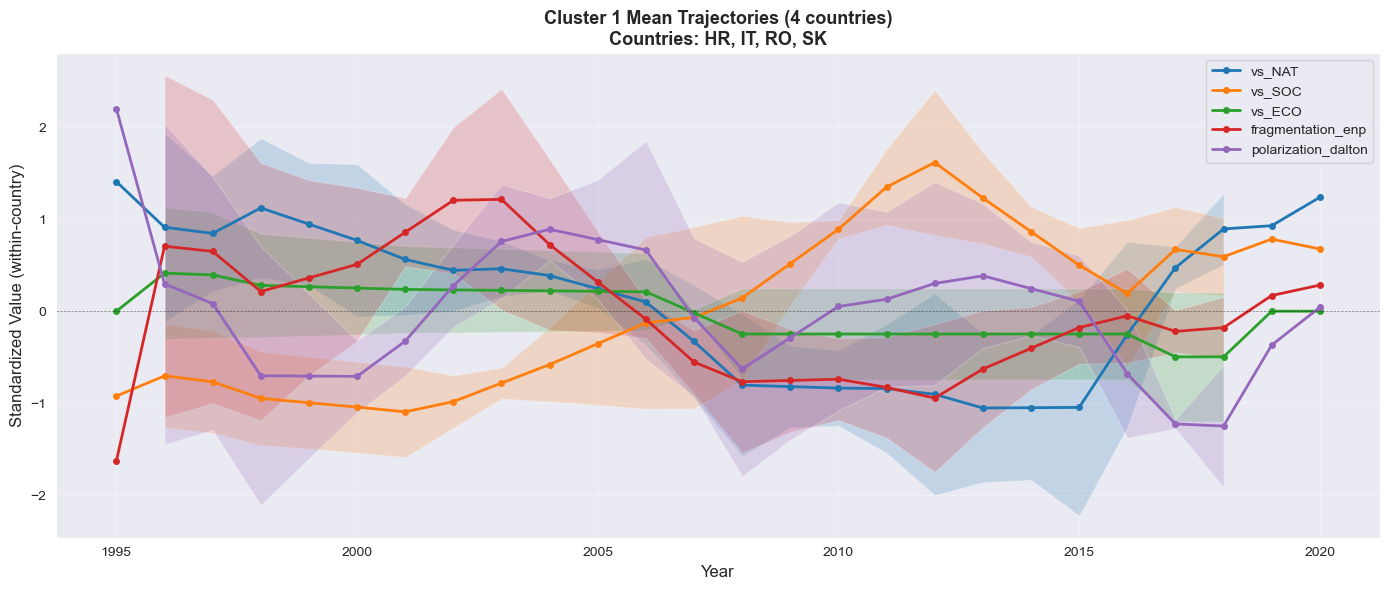

In [29]:
def plot_cluster_trajectories(clusters_df, standardized_data, cluster_features,
                               features_to_plot=['vs_NAT', 'vs_SOC', 'vs_ECO',
                                                'fragmentation_enp', 'polarization_dalton']):
    """
    Plot mean trajectories for each cluster.
    """
    features_to_plot = [f for f in features_to_plot if f in cluster_features]

    for cluster_id in sorted(clusters_df['cluster'].unique()):
        cluster_countries = clusters_df[clusters_df['cluster'] == cluster_id]['geo'].tolist()

        # Get data for this cluster
        cluster_data = standardized_data[
            standardized_data.index.get_level_values('geo').isin(cluster_countries)
        ]

        # Compute mean and std over years
        cluster_stats = cluster_data.groupby('year')[features_to_plot].agg(['mean', 'std'])

        # Plot
        fig, ax = plt.subplots(figsize=(14, 6))

        for feat in features_to_plot:
            years = cluster_stats.index
            mean = cluster_stats[(feat, 'mean')]
            std = cluster_stats[(feat, 'std')]

            ax.plot(years, mean, label=feat, linewidth=2, marker='o', markersize=4)
            ax.fill_between(years, mean - std, mean + std, alpha=0.2)

        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Standardized Value (within-country)', fontsize=12)
        ax.set_title(f'Cluster {cluster_id} Mean Trajectories ({len(cluster_countries)} countries)\n' +
                     f'Countries: {", ".join(sorted(cluster_countries))}',
                     fontsize=13, weight='bold')
        ax.legend(loc='best')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_cluster_trajectories(clusters_df, standardized_data, cluster_features)

#  Step 9: Geographic Distribution


In [30]:
def analyze_geographic_distribution(clusters_df):
    """
    Check if clusters have geographic coherence.
    """
    regions = {
        'Northern Europe': ['DK', 'EE', 'FI', 'IE', 'LV', 'LT', 'SE'],
        'Western Europe': ['AT', 'BE', 'DE', 'FR', 'LU', 'NL'],
        'Southern Europe': ['CY', 'ES', 'GR', 'IT', 'MT', 'PT', 'SI'],
        'Eastern Europe': ['BG', 'CZ', 'HR', 'HU', 'PL', 'RO', 'SK']
    }

    def assign_region(geo):
        for region, countries in regions.items():
            if geo in countries:
                return region
        return 'Other'

    clusters_df['region'] = clusters_df['geo'].apply(assign_region)

    print("\n" + "="*80)
    print("GEOGRAPHIC DISTRIBUTION")
    print("="*80)

    for cluster_id in sorted(clusters_df['cluster'].unique()):
        cluster_data = clusters_df[clusters_df['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id}:")
        region_dist = cluster_data['region'].value_counts()
        for region, count in region_dist.items():
            pct = 100 * count / len(cluster_data)
            print(f"  {region}: {count} ({pct:.1f}%)")

    # Crosstab
    crosstab = pd.crosstab(clusters_df['cluster'], clusters_df['region'], margins=True)
    print("\n" + "="*80)
    print("CLUSTER × REGION CROSSTAB")
    print("="*80)
    print(crosstab)

    return clusters_df

clusters_df = analyze_geographic_distribution(clusters_df)


GEOGRAPHIC DISTRIBUTION

Cluster 0:
  Northern Europe: 7 (31.8%)
  Western Europe: 6 (27.3%)
  Southern Europe: 6 (27.3%)
  Eastern Europe: 3 (13.6%)

Cluster 1:
  Eastern Europe: 3 (75.0%)
  Southern Europe: 1 (25.0%)

CLUSTER × REGION CROSSTAB
region   Eastern Europe  Northern Europe  Southern Europe  Western Europe  All
cluster                                                                       
0                     3                7                6               6   22
1                     3                0                1               0    4
All                   6                7                7               6   26
